In [1]:
# coding: utf-8
import re
import math
import csv
import sys
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from obspy import UTCDateTime, Stream, Trace

%matplotlib inline

In [2]:
def unpackAfile(infile):

# == opening Afile ==
    b = os.path.getsize(infile)
    FH = open(infile, 'rb')
    line = FH.read(b)
    fileHeader = struct.unpack("<4s3h6bh6s", line[0:24])

    fileLength = fileHeader[3]
    port = fileHeader[10]
    # FirstStn = fileHeader[11][0:4].decode('ASCII').rstrip()
# =================================Header=================================

    portHeader = []
    for i in range(24, port * 32, 32):
        port_data = struct.unpack("<4s4s3sbh2b4s12b", line[i:i+32])
        portHeader.append(port_data)

# =================================Data===================================

    dataStartByte = 24+int(port)*32
    dataPoint = 3*int(port)*int(fileLength)*100
    times = int(port)*3*4
    data = []

    data = struct.unpack("<%di" % dataPoint, line[dataStartByte:dataStartByte + dataPoint*4])


    portHeader = np.array(portHeader)
    data = np.array(data)
    idata = data.reshape((3,port,fileLength*100),order='F')

#== write to obspy Stream --
    sttime = UTCDateTime(fileHeader[1], fileHeader[4], fileHeader[5], fileHeader[6], fileHeader[7], fileHeader[8], fileHeader[2])
    npts = fileHeader[3]*fileHeader[9]
    samp = fileHeader[9]
    afst = Stream()
    
    for stc in range(fileHeader[10]):
        stn = portHeader[stc][0].decode('ASCII').rstrip()
        instrument = portHeader[stc][1].decode('ASCII').rstrip()
        loc = '0'+str(portHeader[stc][6].decode('ASCII'))
        net = str(portHeader[stc][7].decode('ASCII')).rstrip()
        GPS = int(portHeader[stc][3])
        
        # remove GPS unlock or broken station
        if ( GPS == 1 or GPS == 2 ):
            chc = 0
            if instrument == 'FBA':
                chc = 1
            elif instrument == 'SP':
                chc = 4
            elif instrument == 'BB':
                chc = 7
            
            for ch in range(3):
                chn = 'Ch'+str(chc+ch)
                
                stats = {'network': net, 'station': stn, 'location': loc,
                        'channel': chn, 'npts': npts, 'sampling_rate': samp,
                        'starttime': sttime}
                
                data = np.array(idata[ch][stc], dtype=float)
                sttmp = Stream([Trace(data=data, header=stats)])
                afst += sttmp

    return afst

In [3]:
def unpackPfile(infile):
    
    with open(infile) as f:
        lines = f.readlines()
    
    tmp = lines[0]
    year = int(tmp[1:5])
    month = int(tmp[5:7])
    day = int(tmp[7:9])
    hour = int(tmp[9:11])
    minute = int(tmp[11:13])
    sec = float(tmp[13:19])

    dt = datetime(year,month,day,hour,minute,int(sec//1),int(sec%1 * 1000000))
    mag = float(tmp[40:44])

    pfile_info = {}
    pfile_info["ori_time"] = dt
    pfile_info["mag"] = mag

    intensity = {}
    arrival_time = {}
    weighting = {}
    pga = {}
    for i in lines[1:]:
        sta = i[:5].strip() # strip 去掉左右空格
        weighting[sta] = int(float(i[35:39]))
        if i[76:77]==" ":
            intensity[sta] = int(0)
        else:
            intensity[sta] = int(i[76:77])
        pga[sta] = float(i[78:83])
        arrival_time[sta] = pfile_info["ori_time"].replace(minute=int(i[21:23]),second=0,microsecond=0) + timedelta(seconds=float(i[23:29]))
    pfile_info["intensity"] = intensity
    pfile_info["arrival_time"] = arrival_time
    pfile_info["weighting"] = weighting
    pfile_info["pga"] = pga
    
    return pfile_info

In [4]:
Afile=unpackAfile("17010623.A20")

In [5]:
Pfile=unpackPfile("17010623.P20")

In [6]:
Afile1=Afile.copy()

In [7]:
station_list=[]
for i,j in Pfile['intensity'].items():
    if j >0:
        station_list.append(i)
        print(i,j)

ENA 4
EHP 1
ESA 2
TWC 2
NDS 2
ETL 1
ENT 1
NDT 1
ETLH 1
NNS 1


In [8]:
st_list=[]
for i in Afile1:
    if i.stats.channel=="Ch1" and i.stats.location=="01" and i.stats.station in station_list:
        st_list.append(i)
        print(i)

SMT.EHP.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples
SMT.ENT.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples
BH.ESA.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples
SMT.ETL.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples
BH.ETLH.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples
BH.NDS.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples
BH.NDT.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples
SMT.NNS.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples
SMT.TWC.01.Ch1 | 2020-05-01T06:23:30.000000Z - 2020-05-01T06:26:09.990000Z | 100.0 Hz, 16000 samples


In [9]:
st_time = UTCDateTime("2020-05-01T06:23:40")
ed_time = UTCDateTime("2020-05-01T06:24:15")
st_list_cut=Stream()
for i in st_list:
    st_list_cut = st_list_cut+i.slice(st_time,ed_time)
    

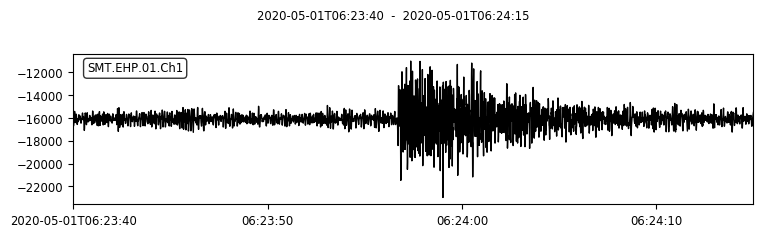

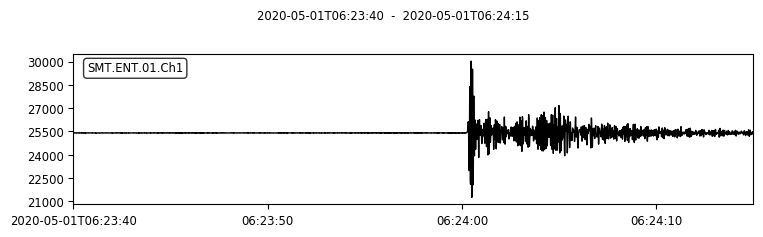

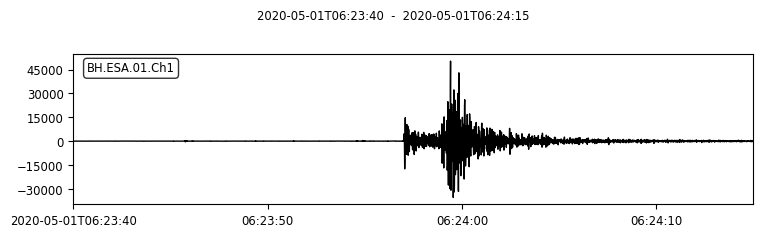

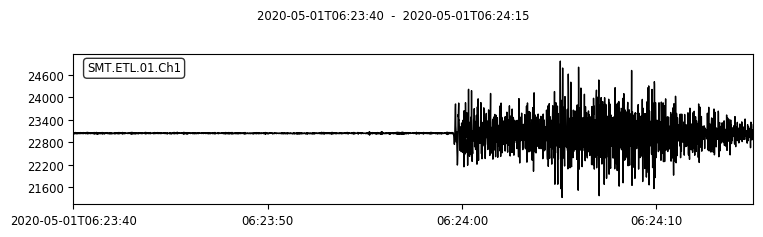

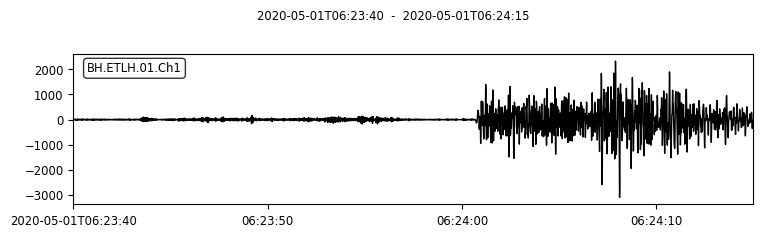

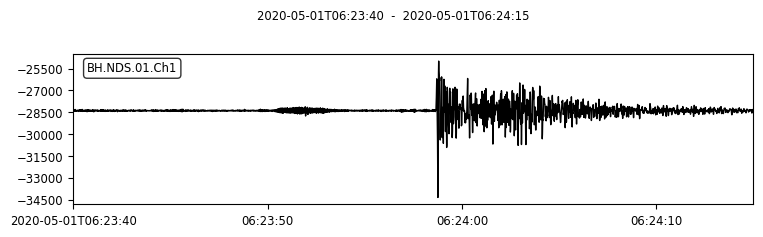

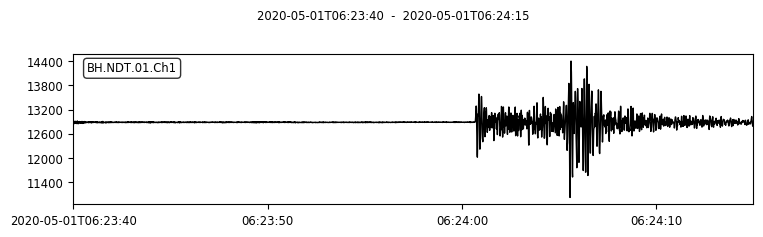

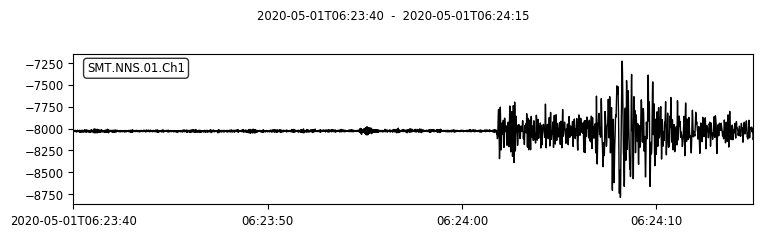

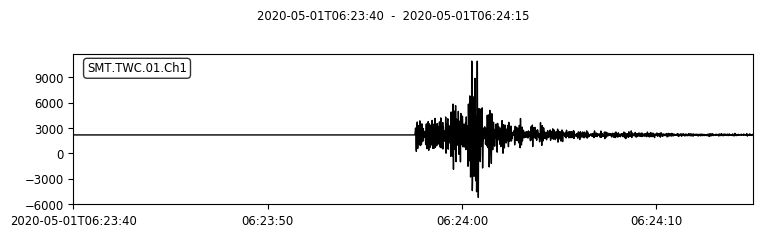

In [10]:
for i in st_list_cut:
    i.plot()

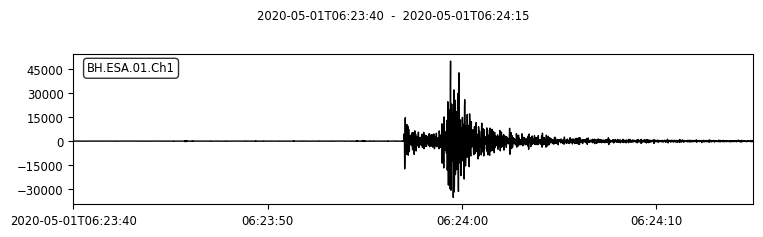

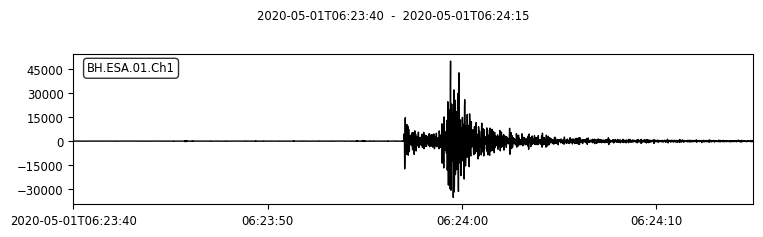

In [11]:
tr = st_list_cut[2].copy()
tr.detrend()
tr.plot()

In [12]:
tr.filter("highpass",freq=1,corners=2)

BH.ESA.01.Ch1 | 2020-05-01T06:23:40.000000Z - 2020-05-01T06:24:15.000000Z | 100.0 Hz, 3501 samples

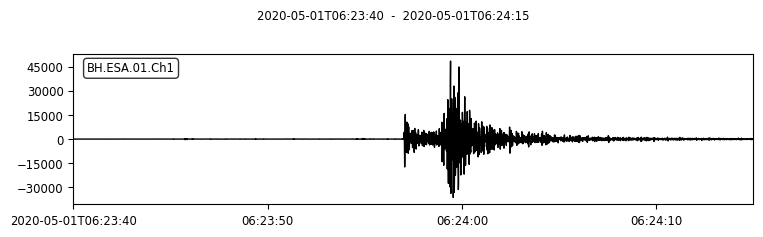

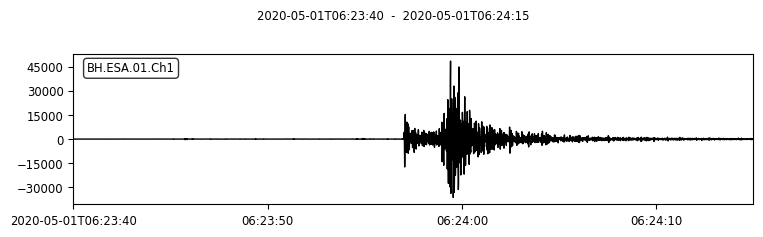

In [13]:
tr.plot()

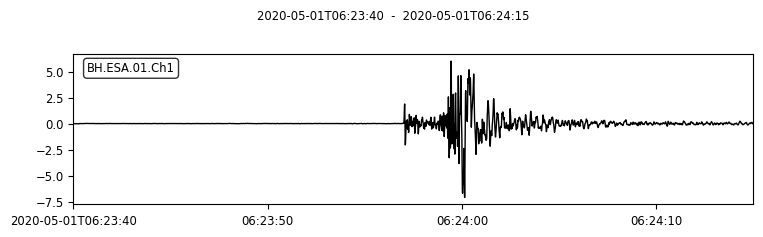

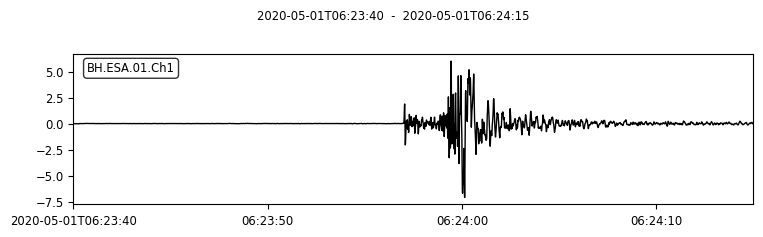

In [14]:
tr.integrate()
tr.integrate()
tr.filter("highpass",freq=1,corners=2)
tr.plot()